# Atividade 4 - Resistência dos Materiais

Aluno 1: Júlia Zoffoli Caçaador - 202365520B

Aluno 2: Robert Gonçalves Vieira de Souza - 202365505B

Aluno 3: Rubia Danielle Viol - 202365515B

## Resolução da Atividade 2 (Exercício 1)

In [ ]:
from sympy import symbols, integrate, Eq, solve, Heaviside, lambdify
import matplotlib.pyplot as plt
import numpy as np
import math
import string
%matplotlib inline

# CONSTANTES
letras = string.ascii_uppercase[:100]
enumCarregamento = {1: "Retangular", 2: "Triangular", 3: "Trapézoidal"}
enumApoio = {1: "Apoio de 1° gênero", 2: "Apoio de 2° gênero", 3: "Apoio de 3° gênero"}
enumEstabilidade = {1: "Hipoestática", 2: "Isostática", 3: "Hiperestática"}

def heaviside(x):
    return 1.0 if x >= 0 else 0.0

class CarregamentoPontual:
    def __init__(self, intensidade, posicao, angulacao):
      self.fy, self.fx = self.separaComponentes(intensidade, angulacao)
      self.posicao = posicao

    def separaComponentes(self, F, theta):
      theta = math.radians(theta)
      x = F * math.cos(theta)
      y = F * math.sin(theta)
      return x,y

class CarregamentoDistribuido:
  def __init__(self, tipo, w0, w1, p0, pf): #construtor
    self.tipo = enumCarregamento[tipo]
    self.w = [w0, w1] # w inicial e w final
    self.p = [p0, pf] # posição inicial e final

    self.x = symbols('x')
    self.resultante = integrate(self.funcao_w(), (self.x, self.p[0],self.p[1])) # calculo da integral de w(x) definida no intervalo de p0 a pf para encontrar a resultante
    self.centroide = integrate(self.funcao_w()*self.x, (self.x, self.p[0],self.p[1]))/self.resultante # calculo do centroide (posição em que a força resultante será aplicada)

  def funcao_w (self):
    if self.w[0] == self.w[1]:
      funcao_w = self.w[0]
    else:
      a = (self.w[1] - self.w[0])/(self.p[1] - self.p[0])
      b = self.w[0] - a*self.p[0]
      funcao_w = a*self.x + b

    return funcao_w

class Apoio:
    def __init__(self, letra, tipo, posicao = 0):
      self.letra = letra
      self.tipo = enumApoio[tipo]
      self.posicao = posicao

      self.fx = symbols(f'{letra}_x')
      self.fy = symbols(f'{letra}_y')

      if(self.tipo == enumApoio[1]):
        self.fx = 0

class Viga:
  def __init__(self):
    self.lista_apoios = []

    self.lista_carregamentos_pontuais = []
    self.lista_carregamentos_distribuidos = []
    self.lista_carregamentos = []

    self.comprimento = 0

    self.solucao = None

    self.V_vals = []
    self.M_vals = []

  def gerar_numIncognitas(self):
    numIncognitas = 0
    for i in range (len(self.lista_apoios)):
      if self.lista_apoios[i].tipo == enumApoio[1]:
        numIncognitas += 1
      elif self.lista_apoios[i].tipo == enumApoio[2]:
        numIncognitas += 2
      elif self.lista_apoios[i].tipo == enumApoio[3]:
        numIncognitas += 3
    return numIncognitas

  def get_estabilidade(self):
    numIncognitas = self.gerar_numIncognitas()
    if numIncognitas > 3:
      return enumEstabilidade[3]
    elif numIncognitas == 3:
      return enumEstabilidade[2]
    else:
      return enumEstabilidade[1]

  def calcula_reacoes(self):
    vars_fx = []
    vars_fy = []
    M = 0
    soma = 0

    for i in range(len(self.lista_apoios)):
      if(self.lista_apoios[i].tipo != enumApoio[1]): vars_fx.append(self.lista_apoios[i].fx)

      vars_fy.append(self.lista_apoios[i].fy)

      if(self.lista_apoios[i].tipo == enumApoio[3]):
        M = symbols('M')
        soma += M

      if self.lista_apoios[i].tipo != enumApoio[3] and i > 0:
        soma += self.lista_apoios[i].fy*(self.lista_apoios[i].posicao - self.lista_apoios[0].posicao)

    for carregamento in self.lista_carregamentos: soma -= carregamento.fy*carregamento.posicao

    fx = Eq(sum(vars_fx) - sum(self.lista_carregamentos[i].fx for i in range(len(self.lista_carregamentos))), 0) # soma de todos fx - soma dos carregamentos em fx
    fy = Eq(sum(vars_fy) - sum(self.lista_carregamentos[i].fy for i in range(len(self.lista_carregamentos))), 0) # soma de todos fy - soma dos carregamentos em fy
    momento = Eq(soma, 0)

    self.solucao = solve((fx, fy, momento), *vars_fx, *vars_fy, M) #solução

    return self.solucao

  def calcular_esforcos_internos(self, x):
      V = 0
      M = 0

      for apoio in self.lista_apoios:
          if apoio.fy in self.solucao:
              reacao = self.solucao[apoio.fy]
              pos = apoio.posicao
              V += reacao * heaviside(x - pos)
              M += reacao * (x - pos) * heaviside(x - pos)

      for carga in self.lista_carregamentos_pontuais:
          Fy = carga.fy
          pos = carga.posicao
          V -= Fy * heaviside(x - pos)
          M -= Fy * (x - pos) * heaviside(x - pos)

      for carga_dist in self.lista_carregamentos_distribuidos:
          a = carga_dist.p[0]
          b = carga_dist.p[1]

          if carga_dist.tipo == "Retangular":
              w = carga_dist.w[0]

              if x > a:
                  if x <= b:
                      V -= w * (x - a)
                      M -= w * (x - a)**2 / 2
                  else:
                      V -= w * (b - a)
                      M -= w * (b - a)**2 / 2 + w * (b - a) * (x - b)

          elif carga_dist.tipo in ["Triangular", "Trapézoidal"]:
              w1 = carga_dist.w[0]
              w2 = carga_dist.w[1]

              if x > a:
                  if x <= b:
                      alpha = (x - a) / (b - a)
                      w_x = w1 + (w2 - w1) * alpha
                      V -= (w1 + w_x) * (x - a) / 2
                      M -= (2 * w1 + w_x) * (x - a)**2 / 6
                  else:
                      R = (w1 + w2) * (b - a) / 2
                      xc = (b - a) * (2 * w1 + w2) / (3 * (w1 + w2))
                      M_b = (w1 + w2) * (b - a)**2 / 6
                      V -= R
                      M -= M_b + R * (x - (a + xc))

      return V, M

  def calcular_Mx_Vx(self):
    pontos_transicao = set()
    for carga in self.lista_carregamentos_distribuidos:
      pontos_transicao.add(carga.p[0])
      pontos_transicao.add(carga.p[1])
    for carga in self.lista_carregamentos_pontuais:
        pontos_transicao.add(carga.posicao)
    for apoio in self.lista_apoios:
        pontos_transicao.add(apoio.posicao)

    x_base = np.linspace(0, self.comprimento, 500)
    x_transicao = []

    for p in pontos_transicao:
        # Garante que os pontos de transição não ultrapassem o comprimento da viga
        start = max(p - 0.001, 0)
        end = min(p + 0.001, self.comprimento)
        x_transicao.extend(np.linspace(start, end, 10))

    x_vals = np.sort(np.unique(np.concatenate([x_base, x_transicao])))
    x_vals = x_vals[x_vals <= self.comprimento]  # Remove pontos além do comprimento

    for x in x_vals:
        V, M = self.calcular_esforcos_internos(x)
        self.V_vals.append(V)
        self.M_vals.append(M)

    return x_vals, self.V_vals, self.M_vals

  def plotar_diagramas(self):
    x_vals, _, _ = self.calcular_Mx_Vx()

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(x_vals, self.V_vals, 'b')
    plt.title('Diagrama de Força Cortante')
    plt.xlabel('Posição (m)')
    plt.ylabel('V(x) [N]')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(x_vals, self.M_vals, 'r')
    plt.title('Diagrama de Momento Fletor')
    plt.xlabel('Posição (m)')
    plt.ylabel('M(x) [Nm]')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

  def plotar_viga(self):
    plt.figure(figsize=(12, 6))

    # Plota viga
    plt.plot([0, self.comprimento], [0, 0], 'k-', linewidth=2)

    # Plota apoios
    for apoio in self.lista_apoios:
      if apoio.tipo == enumApoio[1]:  # Apoio de 1º gênero
        plt.plot([apoio.posicao], [0], 'k^', markersize=10, label=f'Apoio {apoio.letra} de 1° gênero')
      elif apoio.tipo == enumApoio[2]:  # Apoio de 2º gênero
        plt.plot([apoio.posicao], [0], 'ko', markersize=10, label=f'Apoio {apoio.letra} de 2° gênero')
      elif apoio.tipo == enumApoio[3]:  # Apoio de 3º gênero
        plt.plot([apoio.posicao], [0], 'ks', markersize=10, label=f'Apoio {apoio.letra} de 3° gênero')

    # Plota cargas
    for carga in self.lista_carregamentos_pontuais:
      plt.arrow(carga.posicao, 2, 0, -1.5, head_width=0.1, head_length=0.2, fc='blue', ec='blue', label='Carga Pontual')

    for carga in self.lista_carregamentos_distribuidos:
      x = np.linspace(carga.p[0], carga.p[1], 100)
      if carga.tipo == "Retangular":
        y = np.ones_like(x) * carga.w[0]
        label = 'Carga Distribuída Retangular'
      elif carga.tipo == "Triangular":
        y = np.linspace(carga.w[0], carga.w[1], 100)
        label = 'Carga Distribuída Triangular'
      else:
        y = np.linspace(carga.w[0], carga.w[1], 100)
        label = 'Carga Distribuída Trapézoidal'
      plt.fill_between(x, 0, -y / 1000, alpha=0.3, label=label)

    # Plota reações nos apoios
    escala = 1  # Fator de escala para as reações
    for apoio in self.lista_apoios:
      plt.arrow(apoio.posicao, 0, 0, 2, head_width=0.1, head_length=0.2, fc='red', ec='red')  # Seta vertical

      if apoio.tipo != enumApoio[1]:
        plt.arrow(apoio.posicao - 2.5, 0, 2, 0, head_width=0.1, head_length=0.2, fc='red', ec='red')  # Seta horizontal

    plt.grid(True)
    plt.axis('equal')
    plt.title('Análise da Viga')
    plt.xlabel('Posição (m)')
    plt.ylabel('Carga (N/m)')
    plt.legend()
    plt.show()

  def imprimir_resultados(self):
    print("\n\n====================================")
    print(f"RESULTADO:")
    print("====================================")

    for i in range(len(self.lista_carregamentos)):
        print(f"\nCarregamento {i+1}:")
        print(f"Fx: {self.lista_carregamentos[i].fx:.2f}")
        print(f"Fy: {self.lista_carregamentos[i].fy:.2f}")
        print(f"Posição: {self.lista_carregamentos[i].posicao:.2f}")

    print("\n====================================")
    print("\nReações nos apoios:")
    for dado in self.solucao:
        print(f"{dado}: {self.solucao[dado]:.2f}")
    print("\n====================================")

  def menu_viga(self):
    print("\n=== ADICIONE A VIGA ===")
    print("\nTIPOS DE CARREGAMENTO:")
    carregamentos_pontuais = int(input("Insira quantos carregamentos pontuais existem na sua viga: "))
    carregamentos_distribuidos = int(input("Insira quantos carregamentos distribuídos existem na sua viga: "))

    if(carregamentos_pontuais > 0):
      print("\nCARREGAMENTO PONTUAL:")

      for i in range (carregamentos_pontuais):
        intensidade = float(input(f"Insira a intensidade da {i+1}° carga pontual (N): "))
        posicao = float(input(f"Insira a posição da {i+1}° carga pontual (m): "))
        angulacao = float(input(f"Insira a angulação em relação ao eixo y da {i+1}° carga pontual: "))

        self.lista_carregamentos_pontuais.append(CarregamentoPontual(intensidade, posicao, angulacao))

    if(carregamentos_distribuidos > 0):
      print("\nCARREGAMENTO DISTRIBUIDO:")
      print("\nTIPOS DE CARREGAMENTOS DISTRIBUIDOS:")
      print("1. Retangular")
      print("2. Triangular")
      print("3. Trapézoidal")

    w0, w1, p0, p1 = 0, 0, 0, 0
    for i in range (carregamentos_distribuidos):
      tipo = int(input(f"\nInsira o número correspondente ao tipo do {i+1}° carregamento distribuido: "))

      if(tipo == 1):
        w0 = float(input(f"Insira w do {i+1}° carregamento distribuido (N/m): "))
        w1 = w0
      else:
        w0 = float(input(f"Insira w{i} do {i+1}° carregamento distribuido (N/m): "))
        w1 = float(input(f"Insira w{i+1} do {i+1}° carregamento distribuido (N/m): "))

      p0 = float(input(f"Insira a posição inicial do {i+1}° carregamento distribuido (m): "))
      pf = float(input(f"Insira a posição final do {i+1}° carregamento distribuido (m): "))

      self.lista_carregamentos_distribuidos.append(CarregamentoDistribuido(tipo, w0, w1, p0, pf))

    print("\nAPOIOS:")
    num_apoios = int(input("Insira quantos apoios existem na sua viga: "))
    lista_apoios = []

    print("\nTIPOS DE APOIO:")
    print("1. Apoio de 1° gênero")
    print("2. Apoio de 2° gênero")
    print("3. Apoio de 3° gênero")

    for i in range (num_apoios):
      tipo_apoio = int(input(f"\nInsira o número correspondente ao tipo do Apoio {letras[i]}: "))
      posicao = float(input(f"Insira a posição do Apoio {letras[i]} (m): "))

      self.lista_apoios.append(Apoio(letras[i], tipo_apoio, posicao))

    self.comprimento = float(input("\nInsira o comprimento da viga (m): "))
    self.lista_carregamentos = [CarregamentoPontual(self.lista_carregamentos_distribuidos[i].resultante, self.lista_carregamentos_distribuidos[i].centroide, 0) for i in range(carregamentos_distribuidos)] + self.lista_carregamentos_pontuais

## Resolução da Atividade 3 (Exercício 1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

class Retangulo:
    def __init__(self, pontos, eh_vazamento=False):
        self.pontos = pontos
        self.eh_vazamento = eh_vazamento

        self.base = abs(pontos[1][0] - pontos[0][0])  # Diferença entre x1 e x2
        self.altura = abs(pontos[2][1] - pontos[1][1])  # Diferença entre y2 e y1
        self.area = self.base * self.altura

        # Calcula o centroide do retângulo
        self.centroide = self.calcula_centroide_retangulo()

        self.Ix_ = 1 / 12 * self.base * self.altura**3
        self.Iy_ = 1 / 12 * self.altura * self.base**3

    def calcula_centroide_retangulo(self):
        """
        Calcula o centroide de um único retângulo.
        """
        x_medio = (self.pontos[0][0] + self.pontos[1][0]) / 2  # Média dos x
        y_medio = (self.pontos[0][1] + self.pontos[2][1]) / 2  # Média dos y
        return (x_medio, y_medio)

class SecaoTranversal:
  def __init__(self):
    self.retangulos = []

    self.centroide = None
    self.Ix = None
    self.Iy = None

  def captura_retangulos(self, eh_vazamento=False):
      num_retangulos = int(input("Insira o número de retângulos existentes na sua figura: "))
      retangulos = []

      for i in range(num_retangulos):
          pontos = []
          print()
          j = 0
          while j < 4:
              entrada = input(f"Digite um ponto no formato x,y correspondente ao {j+1}º vértice do seu {i+1}º retângulo (m): ")

              try:
                  x, y = map(float, entrada.split(','))
                  pontos.append((x, y))
                  j += 1
              except ValueError:
                  print("Entrada inválida! Digite no formato x,y")

          retangulo = Retangulo(self.ordenar_vertices(pontos), eh_vazamento)
          retangulos.append(retangulo)

      return retangulos

  def ordenar_vertices(self, vertices):
      # Ordena os vértices primeiro por y (ascendente) e depois por x (ascendente)
      vertices_ordenados = sorted(vertices, key=lambda v: (v[1], v[0]))

      # Separa os vértices inferiores e superiores
      inferiores = sorted(vertices_ordenados[:2], key=lambda v: v[0])
      superiores = sorted(vertices_ordenados[2:], key=lambda v: -v[0])

      # Junta os vértices na ordem correta
      return [inferiores[0], inferiores[1], superiores[0], superiores[1]]

  def calcula_centroide(self):
      """
      Calcula o centroide de uma figura composta por retângulos.
      O centroide é a média ponderada dos centroides de cada retângulo,
      onde o peso é a área de cada retângulo.
      """
      somatorio_area = 0
      somatorio_x = 0
      somatorio_y = 0

      for retangulo in self.retangulos:
          if retangulo.eh_vazamento:
              area = -retangulo.area  # Área negativa para vazamentos
          else:
              area = retangulo.area

          # Centroide do retângulo
          x_medio, y_medio = retangulo.centroide

          # Acumular para o cálculo do centroide total
          somatorio_area += area
          somatorio_x += x_medio * area
          somatorio_y += y_medio * area

      # Calcular o centroide total
      if somatorio_area == 0:
          raise ValueError("A área total da figura é zero. Não é possível calcular o centroide.")

      x_centroide = somatorio_x / somatorio_area
      y_centroide = somatorio_y / somatorio_area

      self.centroide = (x_centroide, y_centroide)
      return (x_centroide, y_centroide)

  def calcula_momento_inercia(self):
      """
      Calcula o momento de inércia de uma figura composta por múltiplos retângulos.
      Fórmulas:
          Ix = Σ (Ix_ + A * dy²)
          Iy = Σ (Iy_ + A * dx²)
      onde:
          - Ix_ e Iy_ são os momentos de inércia dos retângulos individuais em seus próprios centroides
          - A é a área de cada retângulo (positiva para retângulos principais, negativa para vazamentos)
          - dx e dy são as distâncias entre os centroides individuais e o centroide da figura total
      """
      Ix_total = 0
      Iy_total = 0
      dx = 0
      dy = 0

      for retangulo in self.retangulos:
          # Área do retângulo (positiva para retângulos principais, negativa para vazamentos)
          area = retangulo.area if not retangulo.eh_vazamento else -retangulo.area

          # Centroide do retângulo
          x_medio, y_medio = retangulo.centroide

          # Distâncias ao centroide da figura
          dx = x_medio - self.centroide[0]
          dy = y_medio - self.centroide[1]

          # Cálculo do momento de inércia usando o teorema dos eixos paralelos
          if not retangulo.eh_vazamento:
              Ix_total += retangulo.Ix_ + abs(area) * dy**2  # Usamos abs(area) para garantir que o sinal não afete o cálculo
              Iy_total += retangulo.Iy_ + abs(area) * dx**2

          if retangulo.eh_vazamento:
              Ix_total -= retangulo.Ix_ + abs(area) * dy**2  # Usamos abs(area) para garantir que o sinal não afete o cálculo
              Iy_total -= retangulo.Iy_ + abs(area) * dx**2

      self.Ix = Ix_total
      self.Iy = Iy_total
      return Ix_total, Iy_total

  def plotagem(self):
      plt.figure()
      for retangulo in self.retangulos:
          # Define a cor com base se é um vazamento ou não
          if retangulo.eh_vazamento:
              cor = 'white'  # Vazamentos são plotados como brancos
              borda = 'grey'  # Borda preta para destacar o vazamento
          else:
              cor = 'purple'  # Retângulos principais são plotados em azul
              borda = 'purple'

          # Desenha os retângulos conectando os pontos
          pontos = retangulo.pontos
          pontos.append(pontos[0])  # Fechar o retângulo conectando o último ponto ao primeiro
          x_coords, y_coords = zip(*pontos)
          plt.plot(x_coords, y_coords, marker='o', color=borda, label='Vazamento' if retangulo.eh_vazamento else 'Retângulo Principal')
          plt.fill(x_coords, y_coords, color=cor, edgecolor=borda, alpha=0.8 if not retangulo.eh_vazamento else 1.0)  # Preenchimento

      # Plotar o centroide, se fornecido
      if self.centroide:
          plt.scatter(self.centroide[0], self.centroide[1], color='green', marker='x', label='Centroide', s=100, linewidths=2)

          # Exibir os valores do centroide e momentos de inércia no gráfico
          texto_centroide = f'Centroide: ({self.centroide[0]:.2f}, {self.centroide[1]:.2f})'
          texto_Ix = f'Ix: {self.Ix:.2e}'
          texto_Iy = f'Iy: {self.Iy:.2e}'

          plt.text(0.02, 0.98, texto_centroide, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
          plt.text(0.02, 0.92, texto_Ix, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
          plt.text(0.02, 0.86, texto_Iy, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

      plt.xlabel('X')
      plt.ylabel('Y')
      plt.title('Configuração Final da Figura')
      plt.grid(True)
      plt.legend()
      plt.show()

  def menu_retangulos(self):
      print("\n1. Adicionar figura principal")
      print("2. Adicionar Vazamento")
      print("3. Finalizar e Calcular")

      opcao = int(input("\nInsira a opção desejada: "))

      if opcao == 1:
          self.retangulos.extend(self.captura_retangulos())  # Adiciona retângulos à lista principal
          #plotagem(retangulos)
          return self.menu_retangulos()

      elif opcao == 2:
          self.retangulos.extend(self.captura_retangulos(eh_vazamento=True))  # Adiciona vazamentos
          #plotagem(retangulos)
          return self.menu_retangulos()

      elif opcao == 3:
          if not self.retangulos:
            print("Nenhum retângulo foi adicionado. Adicione retângulos antes de calcular o centroide.")
          else:
            self.calcula_centroide()
            self.calcula_momento_inercia()

            print(f"\nCentroide: {self.centroide[0]:.2f} m, {self.centroide[1]:.2f} m")
            print(f"\nMomento de Inércia em X: {self.Ix:.2e} m⁴")
            print(f"Momento de Inércia em Y: {self.Iy:.2e} m⁴")
            print()

            print("OS GRÁFICOS ESTÃO COMENTADOS, PARA MOSTRA-LOS BASTA DESCOMENTAR PLOTAGEM NO CÓDIGO!")
            #plotagem(retangulos, centroide, Ix, Iy)
            return

      else:
          print("Opção inválida. Tente novamente.")
          return self.menu_retangulos()

## Resolução da Atividade 4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class InclinacaoEDeflexao:
  def __init__(self, viga, I, E, fator=0.5):
    self.viga = viga
    self.x_vals, _, self.M_vals = viga.calcular_Mx_Vx()

    self.I = I  # Momento de inércia
    self.E = E  # Módulo de elasticidade

    self.theta_vals = np.zeros_like(self.x_vals)
    self.vy_vals = np.zeros_like(self.x_vals)

    self.fator = fator

  def aplicar_condicoes_contorno(self, tipo_apoio):
    """
    Aplica condições de contorno baseadas no tipo de apoio
    """
    if tipo_apoio == 'apoio_simples':
      segundo_apoio_pos = self.viga.lista_apoios[1].posicao
      segundo_apoio_idx = np.argmin(np.abs(self.x_vals - segundo_apoio_pos))

      # Ajustar a inclinação mantendo a forma
      inclinacao_atual = (self.vy_vals[segundo_apoio_idx] - self.vy_vals[0]) / (self.x_vals[segundo_apoio_idx] - self.x_vals[0])

      for i in range(len(self.x_vals)):
          self.vy_vals[i] -= inclinacao_atual * (self.x_vals[i] - self.x_vals[0])

      v_apoio = self.vy_vals[segundo_apoio_idx]
      self.vy_vals -= v_apoio

    elif tipo_apoio == 'engaste':
      theta0 = self.theta_vals[0]

      for i in range(len(self.x_vals)):
          self.theta_vals[i] -= theta0
          self.vy_vals[i] -= theta0 * (self.x_vals[i] - self.x_vals[0])

      # Garantir que a deflexão inicial seja zero
      self.vy_vals -= self.vy_vals[0]

  def calcular_inclinacao_deflexao(self):
    """
    Integração numérica para calcular a inclinação e deflexão
    """

    for i in range(1, len(self.x_vals)):
        dx = self.x_vals[i] - self.x_vals[i - 1]

        self.theta_vals[i] = self.theta_vals[i - 1] + (self.M_vals[i - 1] + self.M_vals[i]) * dx / (2 * self.E * self.I)
        self.vy_vals[i] = self.vy_vals[i - 1] + (self.theta_vals[i - 1] + self.theta_vals[i]) * dx / 2

    tipo_apoio = 'apoio_simples'
    if hasattr(self.viga, 'tipo_apoio'):
        tipo_apoio = self.viga.tipo_apoio

    self.aplicar_condicoes_contorno(tipo_apoio)

    return self.x_vals, self.theta_vals, self.vy_vals

  def plotar_viga_deformada(self, fator):
    """
    Plota a viga deformada junto com a viga original.
    """
    max_idx = np.argmax(np.abs(self.vy_vals))
    max_deflexao = self.vy_vals[max_idx]
    max_pos = self.x_vals[max_idx]

    fator_escala = 1000 if max_deflexao <= 0 else min(1000, 1 / max_deflexao)

    plt.figure(figsize=(14, 8))

    # Plotar viga original
    plt.plot(self.x_vals, np.zeros_like(self.x_vals), 'k-', linewidth=2, label='Viga não deformada')

    # Plotar viga deformada
    plt.plot(self.x_vals, self.vy_vals * fator_escala, 'r-', linewidth=2, label=f'Viga deformada (escala {fator_escala}x)')

    # Plotar apoios com tipos diferentes, se aplicável
    for apoio in self.viga.lista_apoios:
        plt.plot([apoio.posicao], [0], 'ko', markersize=10)
        plt.text(apoio.posicao, -0.01, f'Apoio {apoio.letra}', horizontalalignment='center')

    # Marcar ponto de máxima deflexão
    plt.plot(max_pos, max_deflexao * fator_escala, 'go', markersize=8)
    plt.text(max_pos, max_deflexao * fator_escala + fator + 0.01,
             f'Max: {max_deflexao * 1000:.2f} mm @ x={max_pos:.2f}m',
             horizontalalignment='center', fontsize=10, verticalalignment='bottom', color='green')

    # Anotações de deflexão em pontos específicos
    for i in range(0, len(self.x_vals), max(1, len(self.x_vals)//10)):
      if(self.x_vals[max_idx] != self.x_vals[i]):
        plt.text(self.x_vals[i], self.vy_vals[i] * fator_escala,
                f'{self.vy_vals[i] * 1000:.2f} mm', fontsize=8,
                horizontalalignment='center', verticalalignment='bottom')

    min_deflexao = np.min(self.vy_vals)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(-fator, fator)

    plt.title('Deformada da Viga', fontsize=14)
    plt.xlabel('Posição (m)', fontsize=12)
    plt.ylabel(f'Deflexão (amplificada {fator_escala}x)', fontsize=12)

    plt.legend()

    info_text = f"Módulo de Elasticidade (E): {self.E/1e9:.1f} GPa\n"
    info_text += f"Momento de Inércia (I): {self.I:.2e} m⁴\n"
    info_text += f"Deflexão máxima: {max_deflexao * 1000:.2f} mm"
    plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Retornar a deflexão máxima em milímetros
    return max_deflexao * 1000  # convertido para mm

  def plotar_inclinacao(self):
    """
    Plota as inclinações ao longo do comprimento da viga
    """
    plt.figure(figsize=(14, 8))

    # Plotar inclinação
    plt.plot(self.x_vals, self.theta_vals, 'b-', linewidth=2, label='Inclinação θ(x)')

    max_idx = np.argmax(np.abs(self.theta_vals))
    max_theta = self.theta_vals[max_idx]

    # Adicionar mais anotações de valores de inclinação
    for i in range(0, len(self.x_vals), max(1, len(self.x_vals)//10)):
        plt.text(self.x_vals[i], self.theta_vals[i],
                f'{self.theta_vals[i]*1000:.2f} mm', fontsize=8,
                horizontalalignment='center', verticalalignment='bottom')

    plt.grid(True)
    plt.title('Inclinação ao Longo da Viga')
    plt.xlabel('Posição (m)')
    plt.ylabel('Inclinação θ(x) (rad)')
    plt.legend()
    plt.show()

    return max_theta

def analisar_viga_deformada(viga, I, E, fator):
  if viga.solucao is None:
      viga.calcula_reacoes()

  inclinacao_deflexao = InclinacaoEDeflexao(viga, I, E)
  inclinacao_deflexao.calcular_inclinacao_deflexao()

  max_deflexao_mm = inclinacao_deflexao.plotar_viga_deformada(fator)
  max_inclinacao = inclinacao_deflexao.plotar_inclinacao()

  print(f"\nAnálise de Deflexão da Viga:")
  print(f"Deflexão máxima: {max_deflexao_mm:.2f} mm")
  print(f"Inclinação máxima: {max_inclinacao:.4f} rad")

In [ ]:
def definir_secao_transversal():
  print("\n=== ADICIONE A SECÇÃO TRANSVERSAL ===")
  print("1. Definir sua própria seção transversal")
  print("2. Usar uma seção transversal padrão")

  print("\nA seção padrão possui 500x500 milímetros e momento inércia calculado de I = 5.21e-03 m⁴")

  opcao = int(input("\nInsira a opção desejada: "))
  if (opcao != 1 and opcao != 2):
    print("Opção inválida. Tente novamente.")
    return definir_secao_transversal()

  if opcao == 1:
    print("\nDefina a seção transversal da viga: ")
    secao = SecaoTranversal()
    secao.menu_retangulos()

    # Plotar a seção transversal
    #secao.plotagem()
    return secao.Ix

  if opcao == 2:
    return 5.21e-03

def definir_elasticidade():
  res = int(input(f"\nQuer definir o valor de 𝐸 (módulo de elasticidade)? Por padrão está 𝐸 = 205 GPa. (1: Sim, 2: Não): "))
  if(res != 1 and res != 2):
    print("Opção inválida. Tente novamente.")
    return definir_elasticidade()

  if res == 1:
    return float(input(f"Insira o valor de 𝐸 (em GPa): ")) * 1e9  # Converte de GPa para Pa
  elif res == 2:
    return 205e9

def menu():
  # Cria a viga utilizada
  viga = Viga()
  viga.menu_viga()

  if viga.gerar_numIncognitas() != 3:
    raise ValueError("ERRO: Vigas Hiperestáticas e/ou Hipoestáticas não podem ser calculadas.")

  else:
    solucao = viga.calcula_reacoes()
    viga.imprimir_resultados()

  print("OS GRÁFICOS ESTÃO COMENTADOS, PARA MOSTRA-LOS BASTA DESCOMENTAR AS PLOTAGEM NO CÓDIGO!")
  #viga.plotar_viga()

  # Criar a seção transversal
  I = definir_secao_transversal()
  E = definir_elasticidade()

  # Calcular inclinação e deflexão
  analisar_viga_deformada(viga, I=I, E=E, fator=0.5)

menu()



RESULTADO:

Carregamento 1:
Fx: 0.00
Fy: 10000.00
Posição: 6.00

Carregamento 2:
Fx: 0.00
Fy: 10000.00
Posição: 3.00


Reações nos apoios:
A_x: 0.00
A_y: 11000.00
B_y: 9000.00



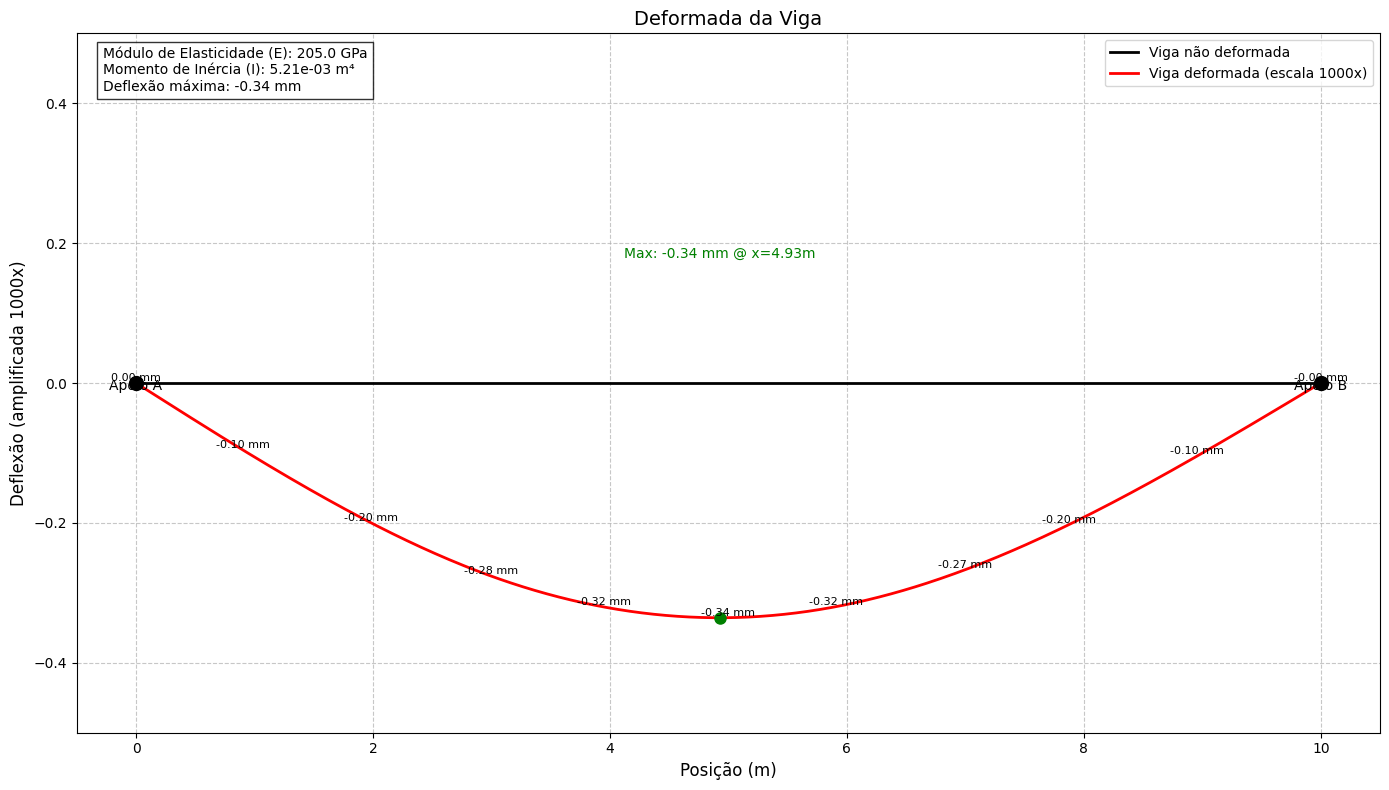

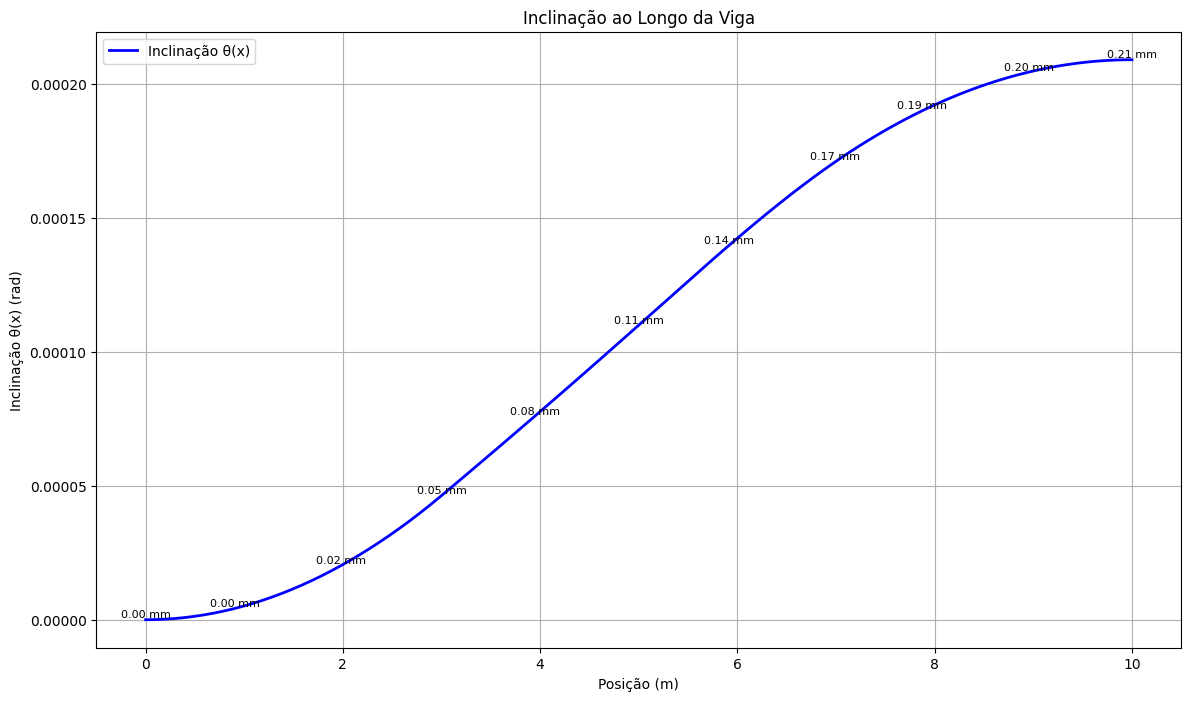


Análise de Deflexão da Viga:
Deflexão máxima: -0.34 mm
Inclinação máxima: 0.0002 rad


In [ ]:
# Exemplo de uso com a nova função
viga = Viga()

viga.lista_carregamentos_pontuais.append(CarregamentoPontual(10000, 3, 0))
#viga.lista_carregamentos_pontuais.append(CarregamentoPontual(5000, 8, 0))
viga.lista_carregamentos_distribuidos.append(CarregamentoDistribuido(1, 5000, 5000, 5, 7))
#viga.lista_carregamentos_distribuidos.append(CarregamentoDistribuido(2, 135000, 0, 3, 5))
#viga.lista_carregamentos_distribuidos.append(CarregamentoDistribuido(3, 60000, 144000, 6, 9))

viga.lista_apoios.append(Apoio('A', 2, 0))
viga.lista_apoios.append(Apoio('B', 1, 10))

viga.comprimento = 10

viga.lista_carregamentos = [CarregamentoPontual(viga.lista_carregamentos_distribuidos[i].resultante, viga.lista_carregamentos_distribuidos[i].centroide, 0) for i in range(len(viga.lista_carregamentos_distribuidos))] + viga.lista_carregamentos_pontuais

solucao = viga.calcula_reacoes()
viga.imprimir_resultados()

# Utilizar a nova função para análise da viga deformada
analisar_viga_deformada(viga, I=5.21e-03, E=205e9, fator=0.5)